In [1]:
import jax
import brainpy as bp
import brainpy.math as bm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

/home/zilong/anaconda3/envs/anticipative_track/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
class adaptiveCANN1D(bp.dyn.NeuDyn):
    def __init__(self, num, tau=0.01, tauv=0.2, m0=1., k=1, a=1.0, A=4., J0=4.,
                 z_min=-bm.pi, z_max=bm.pi):
        super(adaptiveCANN1D, self).__init__(size=num)

        # parameters
        self.tau = tau  # The synaptic time constant
        self.tauv = tauv
        self.k = k # Degree of the rescaled inhibition
        self.a = a  # Half-width of the range of excitatory connections
        self.A = A  # Magnitude of the external input
        self.J0 = J0 # maximum connection value
        self.m = tau/tauv*m0  # The adaptation strength

        # feature space
        self.z_min = z_min
        self.z_max = z_max
        self.z_range = z_max - z_min
        self.x = bm.linspace(z_min, z_max, num)
        self.rho = num / self.z_range  # The neural density
        self.dx = self.z_range / num  # The stimulus density
        self.num = num
        # The connection matrix
        self.conn_mat = self.make_conn()

        # variables
        self.r = bm.Variable(bm.zeros(num))
        self.u = bm.Variable(bm.zeros(num))
        self.v = bm.Variable(bm.zeros(num))
        self.input = bm.Variable(bm.zeros(num))

    def dist(self, d):
        d = bm.remainder(d, self.z_range)
        d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
        return d


    def make_conn(self):
        x_left = bm.reshape(self.x, (-1, 1))
        x_right = bm.repeat(self.x.reshape((1, -1)), len(self.x), axis=0)
        d = self.dist(x_left - x_right)
        conn = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
        return conn

    def get_stimulus_by_pos(self, pos):
        return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

    def update(self):
        #print(bp.share['dt'])
        r1 = bm.square(self.u)
        r2 = 1.0 + self.k * bm.sum(r1)
        self.r.value = r1 / r2
        
        interaction = bm.dot(self.conn_mat, self.r)
        
        self.u.value = self.u + (-self.u + interaction + self.input - self.v) / self.tau * bp.share['dt']
        self.u = bm.where(self.u>0, self.u, 0) #nonnegative constraint
        self.v.value = self.v + (-self.v + self.m * self.u) / self.tauv *  bp.share['dt']

        self.input[:] = 0.

In [20]:
def calculate_inst_speed(directions, samples_per_sec):
    diff_dist = np.diff(directions.flatten())
    #consider the periodic boundary condition that is, if diff > pi, then diff = diff - 2*pi
    #if diff < -pi, then diff = diff + 2*pi
    diff_dist = np.where(diff_dist > np.pi, diff_dist - 2*np.pi, diff_dist)
    diff_dist = np.where(diff_dist < -np.pi, diff_dist + 2*np.pi, diff_dist)
    inst_speed = diff_dist*samples_per_sec
    #insert the first element the same as the second element
    inst_speed = np.insert(inst_speed, 0, 0)
    return inst_speed

In [32]:
# tracking
duration = 360 #in seconds
samples_per_sec = 100
dim = 100 #dimension of the network in each direction
m0= 100 #adaptation strength

#build the network
adapt_cann = adaptiveCANN1D(num=dim, m0=m0, a=1.0)

#prepare the input
data = np.load('./traces/OneDtrajectory_dur360_speedMean0.0_speedStd0.1.npz')
directions = data['Direction']
directions = bm.asarray(directions[:duration*samples_per_sec])

Iext = adapt_cann.get_stimulus_by_pos(directions)

runner = bp.DSRunner(adapt_cann,
                     inputs=['input', Iext, 'iter'],
                     monitors=['r'], dt=0.01)
runner.run(duration)

Predict 36000 steps: : 100%|██████████| 36000/36000 [00:00<00:00, 140895.68it/s]


MovieWriter imagemagick unavailable; using Pillow instead.


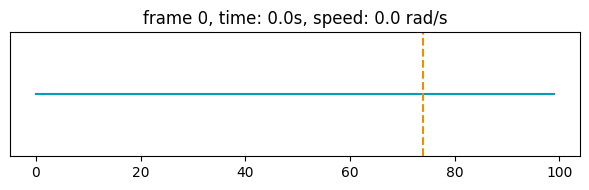

In [33]:
values = runner.mon.r

fig, ax = plt.subplots(figsize=(6, 2), dpi=100)
start = 0
end = 500
values = runner.mon.r[start:end]  # Adjusted for the selected data range.
direction_int = ((directions + np.pi) / (2 * np.pi) * dim).astype(int)[start:end]
speeds = calculate_inst_speed(directions[start:end], samples_per_sec)

def update(i):
    ax.clear()
    # Plot the current frame's values as a line plot.
    ax.plot(values[i], color='#009FB9')
    # Mark the direction as a star on the line plot.
    # ax.plot(direction_int[i], 0, 'r*', markersize=10)
    #Mark the direction as a vertical dashed line on
    ax.axvline(x=direction_int[i], color='#F18D00', linestyle='--')
    
    # Round the speed to 2 decimal places without using np.round.
    round_speed = int(speeds[i] * 100) / 100
    ax.set_title(f'frame {i}, time: {np.round(i / samples_per_sec, 2)}s, speed: {round_speed} rad/s')
    ax.set_yticks([])  # Hide y-axis ticks.
    plt.tight_layout()  # Use tight layout.
    return ax

ani = FuncAnimation(fig, update, frames=len(values), interval=int(1000 / samples_per_sec))

# Save the animation to a file as a gif.
ani.save(f'./animations/adapt1Dcann_ani_m{m0}.gif', writer='imagemagick', fps=samples_per_sec)
